# Projection onto the simplex



<div class="alert alert-block alert-success">
This notebook implements an algorithm for the projection of a vector $y$ onto the simplex $\Delta$ with
\begin{align}
    \Delta := \Big\{ (x_1,\ldots,x_N)\in \mathbb{R}^N:\, \sum_{n=1}^N x_n =a \quad\text{and}\quad x\geq 0 \Big\}.
\end{align}
    
The implemented algorithm was proposed in: Condat, L. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). 
    
The paper is also available at [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Condat's Algorithm</h2>
<ol>
<li>Set $v:= (y_1)$, $u$ as an empty list, $\rho:= y_1 - a$.</li>
<li>For $n \in \{2,\ldots, N\}$, do
<ol>
<li>If $y_n > \rho$
<ol>
<li>Set $\rho := \rho + (y_n - \rho)/(|v|+1)$.</li>
<li>If $\rho > y_n - a$, add $y_n$ to $v$.</li>
<li>Else, add $v$ to $u$, set $v = (y_n)$, $\rho = y_n -a$.</li>
</ol>
</li>
</ol>
</li>
<li>If $u$ is not empty, for every element $y$ of $u$, do
<ol>
<li>If $y > \rho$, add $y$ to $v$ and set $\rho := \rho + (y-\rho)/|v|$.</li>
</ol>
</li>
<li>Do, while $|v|$ changes,
<ol>
<li>For every element $y$ of $v$ do
<ol>
<li>If $y\leq \rho$, remove $y$ from $v$ and set $\rho := \rho + (\rho - y)/|v|$.</li>
</ol>
</li>
</ol>
</li>
<li>Set $\tau := \rho$, $K = |v|$.</li>
<li>For $n \in \{1,\ldots,N\}$, set $x_n := \max \{y_n - \tau, 0\}$.</li>
</ol>
</div>

The algorithm will be tested projecting a random vector $y$ of size $N$ where $y_n \sim \mathcal{U}(-1,2)$ for all $n\in \{1,\ldots,N\}$.

In [1]:
import numpy as np
from numpy import nditer, ndenumerate, zeros, zeros_like, clip, allclose, full, maximum
from numpy.random import default_rng as rng
import math, time

In [2]:
N = 1000
y = rng(0).uniform(-1,2,N)
a = 1.0

## List version

<div class="alert alert-block alert-info">
First implementation is list-based. It sticks to the algorithm above, and thus it cannot take the advantage that $v$ is the list of positive values of $y$, thus requiring the unnecessary triming in Step 6.
</div>

In [3]:
# Step 1
v = [y[0]]
u = []
ρ = y[0] - a

In [4]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( len(v) + 1 )
        if ρ > yₙ - a:
            v.append(yₙ)
        else:
            u.extend(v)
            v = [yₙ]
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for ι in iter(u):
        if ι > ρ:
            v.append(ι)
            ρ += (ι - ρ)/( len(v) )
# Step 4
while True:
    ℓ_v = len(v)
    for ı in range(ℓ_v - 1, -1, -1):
        if v[ı] <= ρ:
            ρ += (ρ - v[ı])/(len(v) - 1)
            del v[ı]
    if len(v) >= ℓ_v:
        break

In [5]:
x = clip(y - ρ, 0, None)

In [6]:
v - ρ

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

## Vectorial version 1

<div class="alert alert-block alert-info">
The following adaptation introduces some array operations to avoid the extra step of clipping negative numbers. Here $v$ is not a set but a boolean array of the same size as $y$. Its cells determine if a cell of $y$ is active in $v$ or not. In the end, $x$ is computed just on the active cells given by $v$.
</div>

In [7]:
# Step 1
ρ = y[0] - a

v = zeros(N, dtype=bool)
x = zeros_like(y)
u = []
v[0] = True

In [8]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( v.sum() + 1 )
        if ρ > yₙ - a:
            v[n] = True
        else:
            u.extend([i[0] for i,j in ndenumerate(v) if j])
            v *= False;    v[n] = True
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for n in iter(u):
        yₙ = y[n]
        if yₙ > ρ:
            v[n] = True
            ρ += (yₙ - ρ)/( v.sum() )
# Step 4
while True:
    ℓ_v = v.sum()
    for i,j in ndenumerate(v):
        if j:
            if y[i[0]] <= ρ:
                ρ += (ρ - y[i[0]])/(v.sum() - 1)
                v[i[0]] = False
    if v.sum() >= ℓ_v:
        break

In [9]:
x[v] = y[v] - ρ #clip(y[v] - ρ, 0.0, None)

In [10]:
x[v]

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

## Vectorial version 2

<div class="alert alert-block alert-info">
The final implementation takes back the original idea of using lists instead of an array of the same size as $y$. In this case, $v$ does not contain values from $y$ but its indeces. This way a sparse representation of $v$ is achieved and $x$ does not go through a clipping step as well.
</div>

In [11]:
# Step 1
ρ = y[0] - a

x = zeros_like(y)
v = [0]
u = []

In [12]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( len(v) + 1 )
        if ρ > yₙ - a:
            v.append(n)
        else:
            u.extend(v)
            v = [n]
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for n in iter(u):
        yₙ = y[n]
        if yₙ > ρ:
            v.append(n)
            ρ += (yₙ - ρ)/( len(v) )
# Step 4
while True:
    ℓ_v = len(v)
    for i,j in enumerate(v):
        if y[j] <= ρ:
            ρ += (ρ - y[j])/(len(v) - 1)
            del v[i]
    if len(v) >= ℓ_v:
        break

In [13]:
x[v] = y[v] - ρ #clip(y[v] - ρ, 0.0, None)

In [14]:
x[v]

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

---

## Performance tests

<div class="alert alert-block alert-warning">
Now we check which routine is the fastest.
</div>

In [15]:
def CondatP_a(y,a,N):
    # Step 1
    v = [y[0]]
    u = []
    ρ = y[0] - a
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(yₙ)
            else:
                u.extend(v)
                v = [yₙ]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for ι in iter(u):
            if ι > ρ:
                v.append(ι)
                ρ += (ι - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for ı in range(ℓ_v - 1, -1, -1):
            if v[ı] <= ρ:
                ρ += (ρ - v[ı])/(len(v) - 1)
                del v[ı]
        if len(v) >= ℓ_v:
            break
            
    return clip(y - ρ, 0, None)

def CondatP_b(y,a,N):
    # Step 1
    ρ = y[0] - a

    v = zeros(N, dtype=bool)
    x = zeros_like(y)
    u = []
    v[0] = True
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( v.sum() + 1 )
            if ρ > yₙ - a:
                v[n] = True
            else:
                u.extend([i[0] for i,j in ndenumerate(v) if j])
                v *= False;    v[n] = True
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v[n] = True
                ρ += (yₙ - ρ)/( v.sum() )
    # Step 4
    while True:
        ℓ_v = v.sum()
        for i,j in ndenumerate(v):
            if j:
                if y[i[0]] <= ρ:
                    ρ += (ρ - y[i[0]])/(v.sum() - 1)
                    v[i[0]] = False
        if v.sum() >= ℓ_v:
            break

    x[v] = y[v] - ρ 
    return x

def CondatP_c(y,a,N):
    # Step 1
    ρ = y[0] - a

    x = zeros_like(y)
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    x[v] = y[v] - ρ
    return x

In [16]:
%timeit -r 10 -n 200 CondatP_a(y,a,N)

200 loops, best of 10: 380 µs per loop


In [17]:
%timeit -r 10 -n 200 CondatP_b(y,a,N)

200 loops, best of 10: 1.91 ms per loop


In [18]:
%timeit -r 10 -n 200 CondatP_c(y,a,N)

200 loops, best of 10: 420 µs per loop


As we can see, the last implementation might be a little faster than the original.

---

## Just-in-time compilation with numba

<div class="alert alert-block alert-warning">
We use numba to speed up the computation time.
</div>

In [19]:
from numba import jit, prange

In [20]:
@jit(nopython=True, fastmath = True, parallel = True)
def CondatP_a(y,a,N):
    # Step 1
    v = [y[0]]
    u = []
    ρ = y[0] - a
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(yₙ)
            else:
                u.extend(v)
                v = [yₙ]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for ι in iter(u):
            if ι > ρ:
                v.append(ι)
                ρ += (ι - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for ı in range(ℓ_v - 1, -1, -1):
            if v[ı] <= ρ:
                ρ += (ρ - v[ı])/(len(v) - 1)
                del v[ı]
        if len(v) >= ℓ_v:
            break
            
    return maximum(y - ρ, 0)

In [21]:
@jit(nopython=True, fastmath = True, parallel = True)
def CondatP_b(y,a,N):
    # Step 1
    ρ = y[0] - a

    v = full(N, False)
    x = zeros_like(y)
    u = []
    v[0] = True
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( v.sum() + 1 )
            if ρ > yₙ - a:
                v[n] = True
            else:
                u.extend([i[0] for i,j in ndenumerate(v) if j])
                v *= False;    v[n] = True
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v[n] = True
                ρ += (yₙ - ρ)/( v.sum() )
    # Step 4
    while True:
        ℓ_v = v.sum()
        for i,j in ndenumerate(v):
            if j:
                if y[i[0]] <= ρ:
                    ρ += (ρ - y[i[0]])/(v.sum() - 1)
                    v[i[0]] = False
        if v.sum() >= ℓ_v:
            break

    x[v] = y[v] - ρ 
    return x

In [22]:
@jit(nopython=True, fastmath = True)#, parallel = True)
def CondatP_c(y,a,N):
    # Step 1
    ρ = y[0] - a

    x = zeros_like(y)
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [23]:
# Run things once for pre-compiling:
CondatP_a(y,a,N), CondatP_b(y,a,N), CondatP_c(y,a,N);

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Now we see a clear winner.

In [24]:
%timeit -r 10 -n 200 CondatP_a(y,a,N)

200 loops, best of 10: 25.3 µs per loop


In [25]:
%timeit -r 10 -n 200 CondatP_b(y,a,N)

200 loops, best of 10: 294 µs per loop


In [26]:
%timeit -r 10 -n 200 CondatP_c(y,a,N)

200 loops, best of 10: 24.2 µs per loop


Finally, a sanity check:

In [27]:
allclose(CondatP_a(y,a,N), CondatP_b(y,a,N)), allclose(CondatP_a(y,a,N), CondatP_c(y,a,N))

(True, True)

---

Now we can finally addapt the code to accept a matrix $\gamma$ as input.

In [28]:
N = 1000
M = 500
γ = rng(0).uniform(-1,2,(N,M))
a = 1.0

In [29]:
y = rng(0).uniform(-1,2,N)
x = zeros_like(γ)

In [30]:
@jit(nopython=True, fastmath = True)#, parallel = True)
def CondatP_c(y,x,a,N):
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [31]:
CondatP_c(y,x,a,N); # Null test

In [32]:
for i in range(N):
    x[i] = CondatP_c(γ[i],x[i],a,M)

In [33]:
# Just checking :)
for i in range(N):
    if x[i].sum() > 2:
        print(i)

26
27
77
94
163
171
194
198
239
252
275
278
308
349
368
405
412
414
497
530
698
734
736
745
762
790
799
812


In [34]:
x.sum(axis=1)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        , 33.17240125,  9.86861806,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [41]:
def indicator_simplex(x, eta, dir = []):
    """
    %
    % This procedure evaluates the indicator function of the constraint set:
    %
    %                  x => 0   AND   1'x = eta
    %
    % When the input 'x' is an array, the computation can vary as follows:
    %  - dir = 0 --> 'x' is processed as a single vector [DEFAULT]
    %  - dir > 0 --> 'x' is processed block-wise along the specified direction
    %
    %  INPUTS
    % ========
    %  x   - ND array
    %  eta - positive, scalar or ND array compatible with the blocks of 'x'
    %  dir - integer, direction of block-wise processing
    """

    # check input
    #sz = size(x); sz(dir) = 1;
    #if any( eta(:) <= 0 ) || ~isscalar(eta) && any(size(eta) ~= sz)
    #    error('''eta'' must be positive and either scalar or compatible with the blocks of ''x''')
    #end


    # linearize
    if not dir:
        x = x[:]
        dir = 1

    # check the constraint
    mask = (np.isclose(x.sum(axis=dir), eta))
    #mask = x.all() & (np.isclose(x.sum(axis=dir), eta))
    #print(x, x.all(), x.sum(axis=dir), eta)
    
    # evaluate the indicator function
    if all(mask[:]):
        p = 0
    else:
        p = math.inf
    return p

In [43]:
def prox_i(y,m,n, v_1, v_2, tol = 1e-5):
    # z = prox(y,m,n,tol) : Computes proximal of the indicator function of the 
    # intersection of the simpleces governed by m and n, respectively.
    #
    # z satisfies sum(y,1) ~ m' and sum(y,2) ~ n with tolerance `tol`.
    #
    # By default, tol = 1e-5.   
    # Recover size of matrix
    M = len(m)
    N = len(n)
    
    # epsilon is selected as a small number
    ep = 0.1

    # Define theta as a fixed value
    the = 2 - ep
    ith = 1/the

    # Initialise z:
    z = y - 0.5 * (v_1 + v_2)
    z[0] = 0.1

    while indicator_simplex(z, m, 1) + indicator_simplex(z, n.T, 0) != 0.0:
        γ_1 = ith * v_1 + z
        γ_2 = ith * v_2 + z
        
        x_1 = zeros_like(γ_1)
        
        for i in range(M):
            x_1[:,i] = CondatP_c(γ_1[:,i],x_1[:,i],n[i],M)
        
        x_2 = zeros_like(γ_2)
        for i in range(N):
            x_2[i,:] = CondatP_c(γ_2[i,:],x_2[i,:],m[i],N)

        # Update v_1 using its projection over simplex C_1^m
        v_1 += the * (z - x_1)
        # Update v_2 using its projection over simplex C_2^n
        v_2 += the * (z - x_2)
        # Update z
        z = y - 0.5 * (v_1 + v_2)

        # The indicator evaluation is too hard for double precision arithmetic.
        # Thus, we relax this condition:
        if all(abs(sum(abs(z),1) - n.T)/n.T < tol):     # Check with lower tol
            if all(abs(sum(abs(z),2) - m)/m < tol):
                z = abs(z)
    return z, v_1, v_2

In [44]:
def FISTA_Backtracking(c,m,n, iters = 100, tol = 1e-4, collect_obj = None):
    """
    % FISTA_Backtracking(c,m,n,collect_obj,tol): Executes the FISTA algorithm
    % applied to problems on optimal transport with backtracking.
    %
    % **Input:**
    % c:   cost matrix of size MxN
    % m:   discrete probability vector of size M
    % n:   discrete probability vector of size N
    % collect_obj: boolean value; if true, then all objective values are stored
    % tol: numerical tolerance of the algorithm: it stops if the norm between a
    %      pair of iterations is less than this value (default tol = 1e-4)
    %
    % **Output:**
    % x:    best feasible point found after optimisation
    % obj:  objective value at x
    % temp: time it took to compute x
    """
    # Recover M and N
    M = len(m)
    N = len(n)

    # First select $\mu$
    mu  = 10^math.ceil(np.log(np.linalg.norm(c,2))/np.log(10)) #norm(c,2);        # 1 -> 10^-1 -> 10^-2 -> ...
    gam = 1/mu

    # x_0 is projected to be a feasible initial point
    #x = (m.T + n)/(N+M)
    x = np.zeros((M,N))
    x[:,0] = m
    x[0,:] = n
    x[0,0] = 0.5 * (m[-1] + n[-1])
    # The initial points for v_1 and v_2 can be built using the information
    # available already from n and m:
    v_1 = np.zeros((M,N))
    v_2 = np.zeros((M,N))
    v_1[:,0] = m
    v_2[0,:] = n
    # Compute proximal operator at C and update v_1 and v_2
    [x, v_1, v_2] = prox_i(x,m,n,v_1,v_2)
    # z_0 is a copy of x_0
    z = x
    t = 1.0

    ## Controls                              
    # The distance between points will serve as stopping criteria
    #norm_difference = Inf;
    # Objective value
    obj = [];
    # initial objective calculation
    if collect_obj:
        obj.append((c*x).sum())

    # Measure time
    start = time.time()

    ## Now we perform the FISTA iteration:
    for it in range(iters):

        # First proximal projection
        y = z - gam * c;
        # Proximal operation
        u, v_1, v_2 = prox_i(y,m,n,v_1,v_2)

        while 4 * (c*(u-z)).sum() > mu * sum(x ** 2 for x in range(len(u))):
            mu  = mu * 2
            gam = 0.5 * gam
            y = z - gam * c
            u, v_1, v_2 = prox_i(y,m,n,v_1,v_2)
            
        if collect_obj:
            obj.append((c*x).sum())

        ## Update momentum
        s = 0.5 * ( 1.0 + np.sqrt( 1 + 4*t**2 ) )
        l = 1 + (t - 1)/s
        z = x + l * (u-x)
        # Iterate info
        norm_difference = np.linalg.norm(x-u)

        #Average objective from 2 previous
        aver_obj = ((c*u).sum() + ((c*x).sum()))/2
        x = u
        t = s
    end = time.time()
    print(end - start, " - Time taken")
    return u, obj

In [49]:
## Exact Test

211.62841272354126  - Time taken
[[ 1.45202311e-06  2.49999130e-01  8.62061795e-07  9.18523672e-07]
 [ 5.55111512e-17  3.46561851e-09  2.77555756e-17  2.50000003e-01]
 [-2.77555756e-16  3.14139365e-09  2.50000003e-01  1.38777878e-16]
 [ 2.50000000e-01  5.55111512e-17  1.11022302e-16 -2.77555756e-16]] 1.2964132141842006


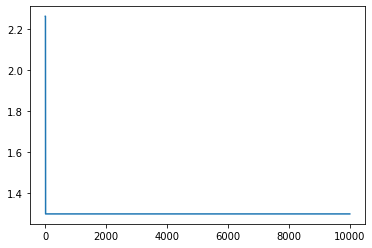

In [48]:
import matplotlib.pyplot as plt
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])
x, obj = FISTA_Backtracking(c,m,n,1000,tol = 1e-8, collect_obj = True)
plt.plot(obj)
print(x, obj[-1])

---